In [1]:
import pandas as pd
import seaborn as sns
import wandb
import os

# Results
Get results from Weights and Biases and produce plots for paper

In [2]:
def get_data_from_wandb():

    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs("messer/JavaDoc-Relevance-Classifier-Renewed")

    summary_list, config_list, name_list, group_list, tag_list = [], [], [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        group_list.append(run.group)
        tag_list.append(run.tags)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "group": group_list,
        "tag": tag_list
    })

    runs_df.to_csv("data/training_results.csv")
    return runs_df

if not os.path.isfile("data/training_results.csv"):
    runs_df = get_data_from_wandb()

### Process WandB API call results

In [3]:
runs_df = pd.read_csv('data/training_results.csv')
runs_df['summary'] = runs_df['summary'].apply(lambda s: eval(s))
runs_df['config'] = runs_df['config'].apply(lambda s: eval(s))
runs_df.head()

,Unnamed: 0,summary,config,name,group,tag
0,0,"{'_runtime': 2.639791250228882, '_step': 20, '...","{'n_neighbours': 3, 'trial.number': 0}",stellar-serenity-596,KNeighbours,"['BoW', 'preprocessed']"
1,1,"{'_runtime': 3.436563014984131, '_step': 20, '...","{'n_neighbours': 4, 'trial.number': 1}",dark-monkey-597,KNeighbours,"['BoW', 'preprocessed']"
2,2,"{'_runtime': 3.64565372467041, '_step': 20, '_...","{'n_neighbours': 7, 'trial.number': 2}",eager-sound-598,KNeighbours,"['BoW', 'preprocessed']"
3,3,"{'_runtime': 3.4758143424987793, '_step': 20, ...","{'n_neighbours': 8, 'trial.number': 3}",kind-durian-599,KNeighbours,"['BoW', 'preprocessed']"
4,4,"{'_runtime': 3.363544225692749, '_step': 20, '...","{'n_neighbours': 2, 'trial.number': 4}",bumbling-sponge-600,KNeighbours,"['BoW', 'preprocessed']"


In [4]:
df = pd.concat([runs_df[['name', 'group', 'config', 'tag']], pd.json_normalize(runs_df['summary'])], axis=1)

df.head()

,name,group,config,tag,_runtime,_step,_timestamp,eval/accuracy,eval/f1_macro,eval/f1_micro,...,total_flos,train/epoch,train/global_step,train/grad_norm,train/learning_rate,train/loss,train_loss,train_runtime,train_samples_per_second,train_steps_per_second
0,stellar-serenity-596,KNeighbours,"{'n_neighbours': 3, 'trial.number': 0}","['BoW', 'preprocessed']",2.639791,20,1.733918e+09,0.575,0.555263,0.575,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dark-monkey-597,KNeighbours,"{'n_neighbours': 4, 'trial.number': 1}","['BoW', 'preprocessed']",3.436563,20,1.733918e+09,0.500,0.502727,0.500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,eager-sound-598,KNeighbours,"{'n_neighbours': 7, 'trial.number': 2}","['BoW', 'preprocessed']",3.645654,20,1.733918e+09,0.350,0.329821,0.350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,kind-durian-599,KNeighbours,"{'n_neighbours': 8, 'trial.number': 3}","['BoW', 'preprocessed']",3.475814,20,1.733918e+09,0.300,0.283129,0.300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bumbling-sponge-600,KNeighbours,"{'n_neighbours': 2, 'trial.number': 4}","['BoW', 'preprocessed']",3.363544,20,1.733918e+09,0.625,0.627635,0.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Group and produce plots

In [5]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

In [6]:
grouped_df = df[['group', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted']].groupby('group').max().reset_index()
grouped_df.columns = ['group', 'accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
grouped_df.group = grouped_df.group.str.replace('Bernolli', 'Bernoulli')
grouped_df

,group,accuracy,precision_weighted,recall_weighted,f1_weighted
0,Bernoulli,0.492063,0.485193,0.492063,0.486449
1,DecisionTree,0.492063,0.574980,0.492063,0.482620
2,Fine-Tuned LLM:bert-base-uncased,0.444444,0.430865,0.444444,0.432769
3,Fine-Tuned LLM:microsoft/codebert-base,0.444444,0.477435,0.444444,0.453137
4,KNeighbours,0.587302,0.658730,0.587302,0.604861
5,LORA:bert-base-uncased,0.476190,0.444497,0.476190,0.452892
6,LORA:microsoft/codebert-base,0.428571,0.516430,0.428571,0.452180
7,LogisticRegression,0.476190,0.497447,0.476190,0.484117
8,RandomForest,0.507937,0.511746,0.507937,0.482924


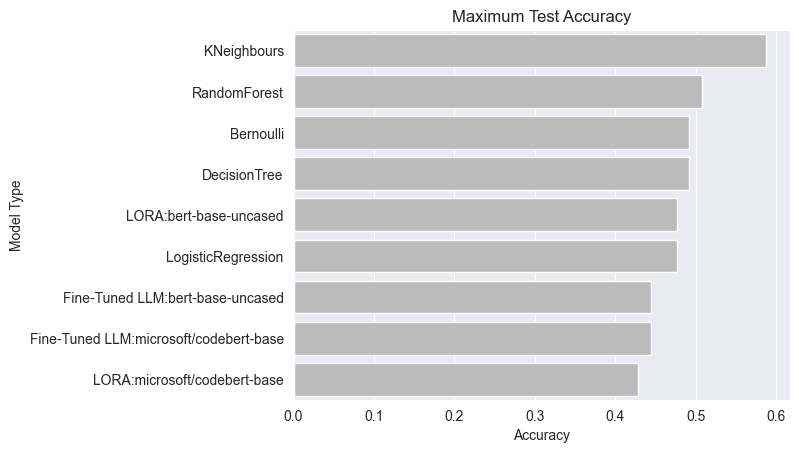

In [7]:
acc = sns.barplot(grouped_df[['group', 'accuracy']].sort_values('accuracy', ascending=False), y='group', x='accuracy', color=grey)
acc.set(title='Maximum Test Accuracy', xlabel='Accuracy', ylabel='Model Type')
acc.get_figure().savefig('plots/accuracy.pdf', bbox_inches='tight')

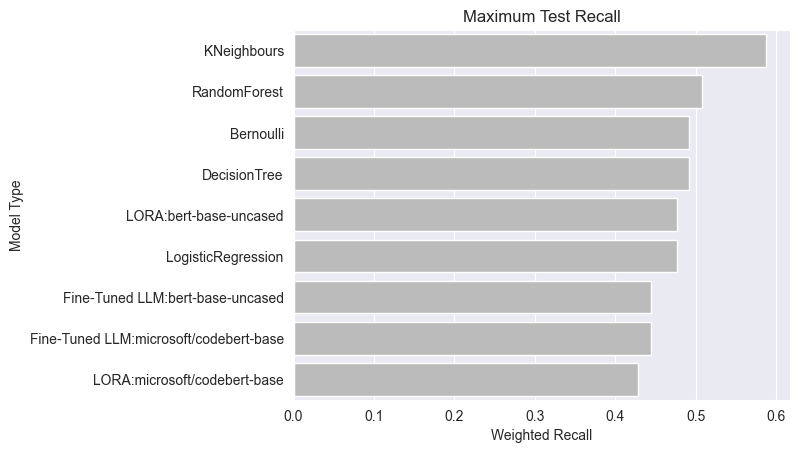

In [8]:
recall = sns.barplot(grouped_df[['group', 'recall_weighted']].sort_values('recall_weighted', ascending=False), y='group', x='recall_weighted', color=grey)
recall.set(title='Maximum Test Recall', xlabel='Weighted Recall', ylabel='Model Type')
recall.get_figure().savefig('plots/recall.pdf', bbox_inches='tight')

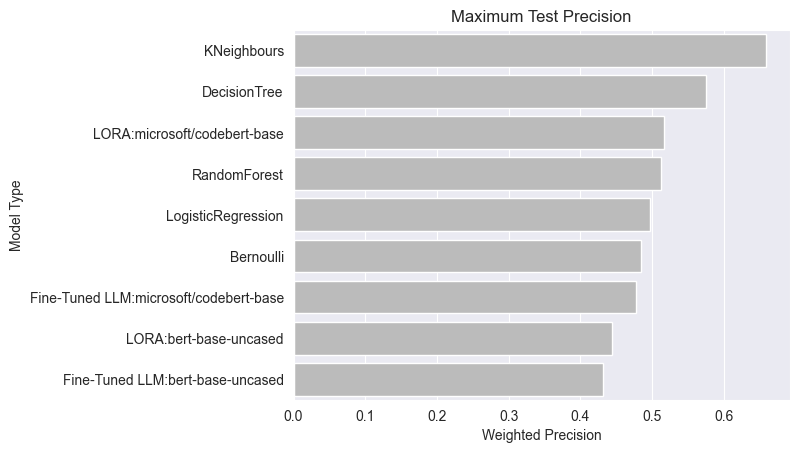

In [9]:
precision = sns.barplot(grouped_df[['group', 'precision_weighted']].sort_values('precision_weighted', ascending=False), y='group', x='precision_weighted', color=grey)
precision.set(title='Maximum Test Precision', xlabel='Weighted Precision', ylabel='Model Type')
precision.get_figure().savefig('plots/precision.pdf', bbox_inches='tight')

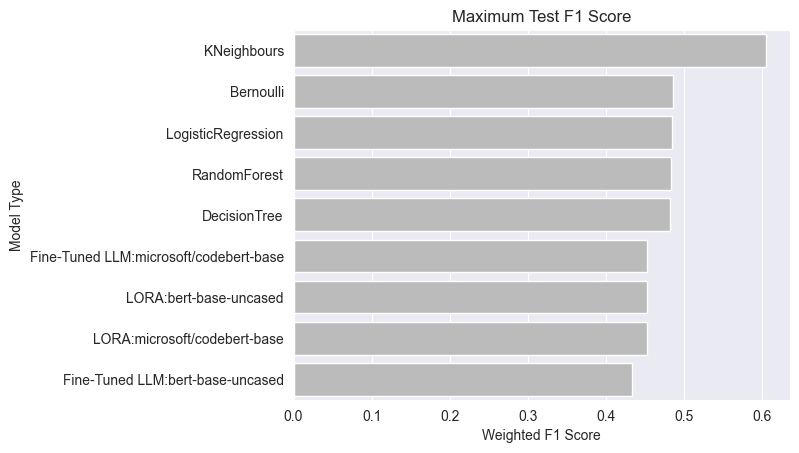

In [10]:
f1 = sns.barplot(grouped_df[['group', 'f1_weighted']].sort_values('f1_weighted', ascending=False), y='group', x='f1_weighted', color=grey)
f1.set(title='Maximum Test F1 Score', xlabel='Weighted F1 Score', ylabel='Model Type')
f1.get_figure().savefig('plots/f1.pdf', bbox_inches='tight')

In [11]:
grouped_df_melted = grouped_df.melt(id_vars=['group'])
grouped_df_melted['variable'] = grouped_df_melted['variable'].map(lambda metric_name: metric_name.title().replace('_Weighted', ''))
grouped_df_melted

,group,variable,value
0,Bernoulli,Accuracy,0.492063
1,DecisionTree,Accuracy,0.492063
2,Fine-Tuned LLM:bert-base-uncased,Accuracy,0.444444
3,Fine-Tuned LLM:microsoft/codebert-base,Accuracy,0.444444
4,KNeighbours,Accuracy,0.587302
5,LORA:bert-base-uncased,Accuracy,0.476190
6,LORA:microsoft/codebert-base,Accuracy,0.428571
7,LogisticRegression,Accuracy,0.476190
8,RandomForest,Accuracy,0.507937
9,Bernoulli,Precision,0.485193


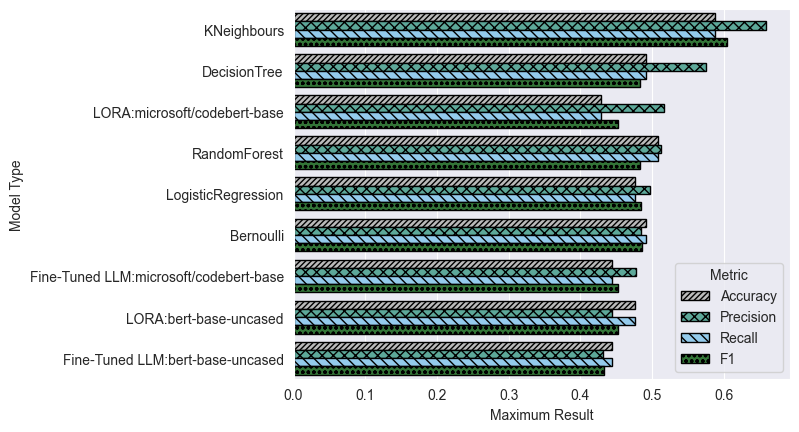

In [12]:
metrics_plt = sns.barplot(grouped_df_melted.sort_values(['value'], ascending=False), y='group', x='value', hue='variable', hue_order=['Accuracy', 'Precision', 'Recall', 'F1'])

hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, metrics_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

metrics_plt.set(xlabel='Maximum Result', ylabel='Model Type')
handles = metrics_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


metrics_plt.legend(title='Metric')

metrics_plt.get_figure().savefig('plots/metric_results.pdf', bbox_inches='tight')

### Top results

In [33]:
top_df = df.sort_values(['test/accuracy'], ascending=False).head(100).reset_index()[['name','group', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted', 'config', 'tag']]
top_df['test/accuracy'] = top_df['test/accuracy'].apply(lambda x: round(x, 3))
top_df['test/precision_weighted'] = top_df['test/precision_weighted'].apply(lambda x: round(x, 3))
top_df['test/recall_weighted'] = top_df['test/recall_weighted'].apply(lambda x: round(x, 3))
top_df['test/f1_weighted'] = top_df['test/f1_weighted'].apply(lambda x: round(x, 3))
top_df[['group','tag', 'config', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted']]

,group,tag,config,test/accuracy,test/precision_weighted,test/recall_weighted,test/f1_weighted
0,KNeighbours,"['TfIdf', 'preprocessed']","{'n_neighbours': 1, 'trial.number': 1}",0.587,0.659,0.587,0.605
1,KNeighbours,"['TfIdf', 'preprocessed']","{'n_neighbours': 2, 'trial.number': 6}",0.571,0.614,0.571,0.587
2,KNeighbours,"['TfIdf', 'preprocessed']","{'n_neighbours': 2, 'trial.number': 0}",0.571,0.614,0.571,0.587
3,RandomForest,"['TfIdf', 'preprocessed']","{'rf_max_depth': 3, 'trial.number': 17}",0.508,0.509,0.508,0.482
4,DecisionTree,"['TfIdf', 'preprocessed']","{'dt_criterion': 'entropy', 'dt_max_depth': 17...",0.492,0.515,0.492,0.481
...,...,...,...,...,...,...,...
95,DecisionTree,"['TfIdf', 'preprocessed']","{'dt_criterion': 'entropy', 'dt_max_depth': 12...",0.429,0.400,0.429,0.406
96,DecisionTree,"['TfIdf', 'preprocessed']","{'dt_criterion': 'gini', 'dt_max_depth': 16, '...",0.429,0.510,0.429,0.397
97,LORA:bert-base-uncased,['preprocessed'],"{'bf16': False, 'fp16': False, 'fsdp': [], 'se...",0.413,0.380,0.413,0.393
98,DecisionTree,"['TfIdf', 'preprocessed']","{'dt_criterion': 'entropy', 'dt_max_depth': 11...",0.413,0.393,0.413,0.401


## Runtime Evalation

In [14]:
runtime_df = df[['group', '_runtime']]
runtime_df.columns = ['group', 'runtime']
runtime_df['timedelta'] = pd.to_timedelta(runtime_df['runtime'], unit='s')

runtime_df.head()


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_45031/3622652944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_df['timedelta'] = pd.to_timedelta(runtime_df['runtime'], unit='s')


,group,runtime,timedelta
0,KNeighbours,2.639791,0 days 00:00:02.639791250
1,KNeighbours,3.436563,0 days 00:00:03.436563015
2,KNeighbours,3.645654,0 days 00:00:03.645653725
3,KNeighbours,3.475814,0 days 00:00:03.475814342
4,KNeighbours,3.363544,0 days 00:00:03.363544226


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_45031/1946738690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_df.group = runtime_df.group.str.replace('Bernolli', 'Bernoulli')


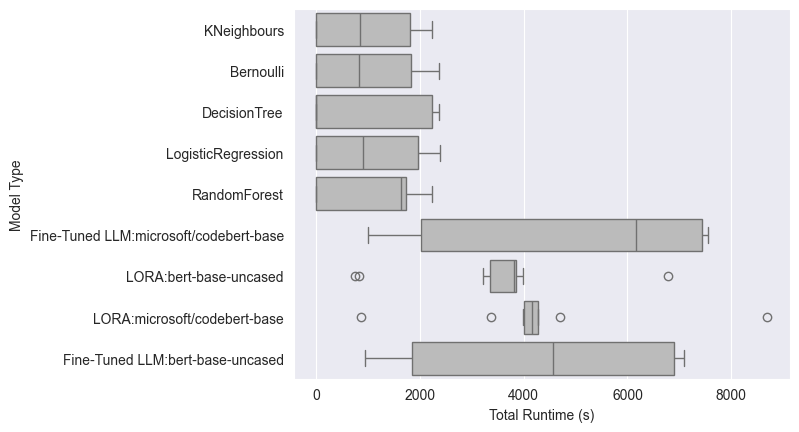

In [15]:
# TODO: Figure out how to change xaxis ticks
runtime_df.group = runtime_df.group.str.replace('Bernolli', 'Bernoulli')


runtime = sns.boxplot(runtime_df, y='group', x='runtime', color=grey)
runtime.set(xlabel='Total Runtime (s)', ylabel='Model Type')

runtime.get_figure().savefig('plots/runtime.pdf', bbox_inches='tight')

In [16]:
avg_runtime = runtime_df.groupby('group').mean().reset_index().sort_values('runtime', ascending=False)
avg_runtime

,group,runtime,timedelta
3,Fine-Tuned LLM:microsoft/codebert-base,5022.358363,0 days 01:23:42.358362627
2,Fine-Tuned LLM:bert-base-uncased,4448.805035,0 days 01:14:08.805034995
6,LORA:microsoft/codebert-base,4255.702845,0 days 01:10:55.702845215
5,LORA:bert-base-uncased,3467.715170,0 days 00:57:47.715169548
7,LogisticRegression,1051.583700,0 days 00:17:31.583699941
8,RandomForest,1024.799613,0 days 00:17:04.799613427
0,Bernoulli,997.852810,0 days 00:16:37.852810394
4,KNeighbours,971.308069,0 days 00:16:11.308068519
1,DecisionTree,813.440726,0 days 00:13:33.440725858


## Oversampling Plot

In [17]:
raw_df = pd.read_csv('data/raw.csv')
proc_df = pd.read_csv('data/proc_train.csv')

raw_df.head()

,func_code_string,label,query,text
0,public static HtmlPage toHtmlPage(String strin...,3,how to get html of website,how to get html of website<CODESPLIT>public st...
1,public static HtmlPage toHtmlPage(WebDriver we...,3,how to get html of website,how to get html of website<CODESPLIT>public st...
2,public static String reverse(String string) {\...,3,how to reverse a string,how to reverse a string<CODESPLIT>public stati...
3,public HtmlElement findHtmlElementById(String ...,2,reading element from html - <td>,reading element from html - <td><CODESPLIT>pub...
4,@NonNull\n public static String getNowDateT...,3,how to get current date,how to get current date<CODESPLIT>@NonNull ...


In [18]:
raw_df['source'] = 'Raw Data'
raw_df = raw_df[['source', 'label']]

raw_df.head()

,source,label
0,Raw Data,3
1,Raw Data,3
2,Raw Data,3
3,Raw Data,2
4,Raw Data,3


<Axes: xlabel='label', ylabel='count'>

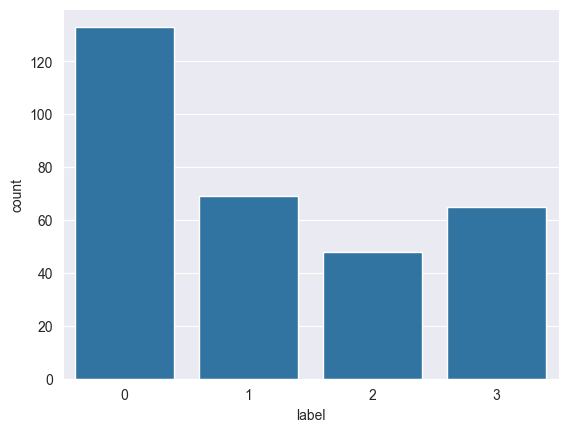

In [19]:
sns.countplot(raw_df, x='label')

In [20]:
proc_df['source'] = 'Oversampled Data'
proc_df = proc_df[['source', 'label']]

proc_df.head()

,source,label
0,Oversampled Data,0
1,Oversampled Data,1
2,Oversampled Data,2
3,Oversampled Data,3
4,Oversampled Data,0


<Axes: xlabel='label', ylabel='count'>

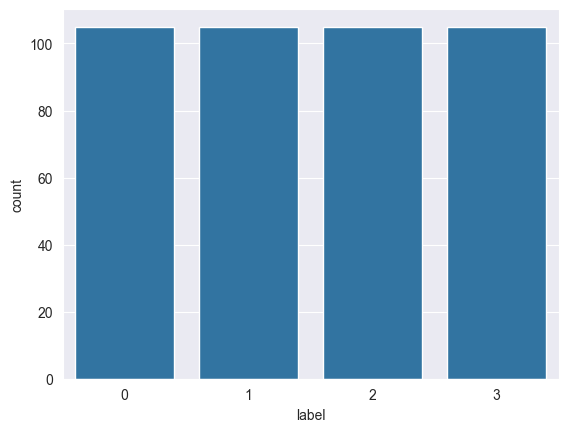

In [21]:
sns.countplot(proc_df, x='label')

<Axes: xlabel='label', ylabel='count'>

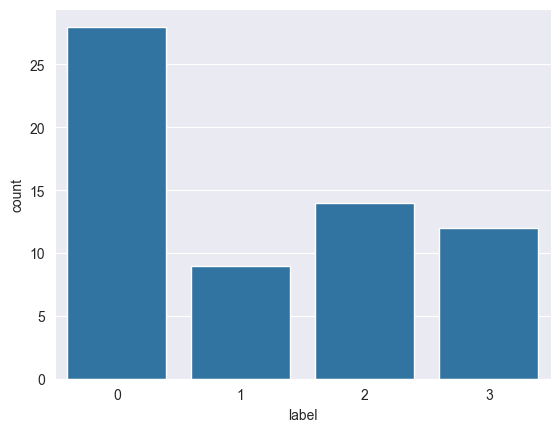

In [22]:
proc_test_df = pd.read_csv('data/proc_test.csv')
sns.countplot(proc_test_df, x='label')

In [23]:
count_df = pd.concat([raw_df, proc_df])
count_df.head()

,source,label
0,Raw Data,3
1,Raw Data,3
2,Raw Data,3
3,Raw Data,2
4,Raw Data,3


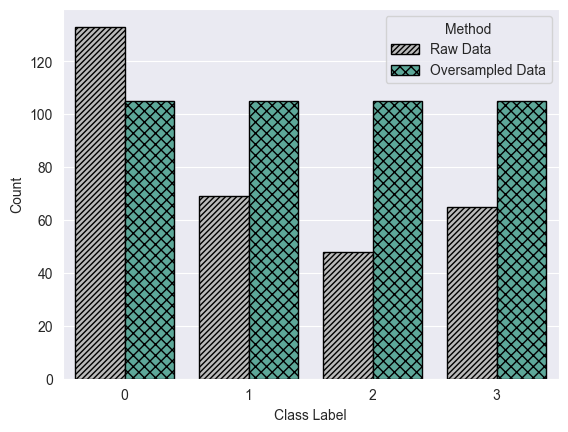

In [24]:
data_plt = sns.countplot(count_df, x='label', hue='source')

hatches = ['//', 'x']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, data_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

data_plt.set(xlabel='Class Label', ylabel='Count')

handles = data_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

data_plt.legend(title='Method')

data_plt.get_figure().savefig('plots/oversampled.pdf', bbox_inches='tight')

In [25]:
test_df = pd.read_csv('data/proc_test.csv')

test_df[['func_code_string', 'query', 'text']].isin(proc_df)

,func_code_string,query,text
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
58,False,False,False
59,False,False,False
60,False,False,False
61,False,False,False
